In [34]:
import caiman as cm
from caiman.base.rois import register_multisession
from caiman.utils import visualization
from caiman.utils.utils import download_demo
from matplotlib import pyplot as plt
import numpy as np
from caiman.source_extraction.cnmf.cnmf import load_CNMF
from caiman.mmapping import save_memmap
from scipy.sparse import csc_matrix
from caiman.utils.visualization import plot_contours, nb_view_patches, nb_plot_contour
import os
import caiman as cm
from caiman.motion_correction import MotionCorrect
from caiman.source_extraction.cnmf import cnmf as cnmf
from caiman.source_extraction.cnmf import params as params
from caiman2Mat import saveCaimain2Mat
from PIL import Image


In [6]:
#testing caiman seeded initialization to maybe be able to semi automate cell indentification

regVideoPath = '/mnt/Brenna_Feb2023/TdTG7_18/TdTG7_18_018/field1_gui/ConcatenatedMovie_MC_reg.tif'
redChannelPath = '/mnt/Brenna_Feb2023/TdTG7_18/TdTG7_18_018/field1_gui/TdTG7_18_018_002_ch2_MC.tif'

In [8]:


#saving memmap of our regVideo
# regVideo = save_memmap([regVideoPath], base_name='testing' + 'mmapFile', order='C')
redDir = os.path.dirname(redChannelPath)
fileName = os.path.basename(redChannelPath)[:-4]

#loading and saving memmap of our reg channel video
movie = cm.load(redChannelPath)
movie.save(os.path.join(redDir,fileName +'Resaved.tif'))

#join selected cells: esc -> select cells -> ctrl + shift + p -> join cells command
newPath = '/mnt/Brenna_Feb2023/TdTG7_18/TdTG7_18_018/field1_gui/TdTG7_18_018_002_ch2_MC_mmapFile.tif'
redVideo = save_memmap([redChannelPath], base_name='testingRed' + 'mmapFile', order='C')

In [9]:
regSession = cm.load('/mnt/Brenna_Feb2023/TdTG7_18/TdTG7_18_018/field1_gui/testingmmapFile_d1_519_d2_724_d3_1_order_C_frames_12961.mmap')

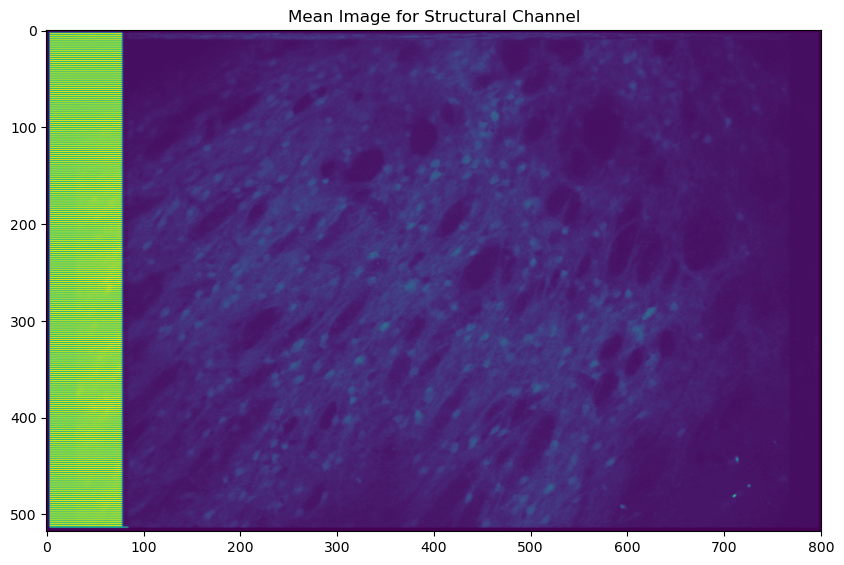

In [10]:
redMemMap = '/mnt/Brenna_Feb2023/TdTG7_18/TdTG7_18_018/field1_gui/testingRedmmapFile_d1_518_d2_801_d3_1_order_C_frames_308.mmap'
R = cm.load(redMemMap)
mR = R.mean(0)

plt.figure(figsize=(10,10))
plt.imshow(mR)
plt.title('Mean Image for Structural Channel')

In [13]:
import cv2
meanRedImage = cv2.imread('/mnt/Brenna_Feb2023/TdTG7_18/TdTG7_18_018/field1_gui/TdTG7_18_018_002_ch2_MC_avg_registered.tif')

In [35]:
im = Image.open('/mnt/Brenna_Feb2023/TdTG7_18/TdTG7_18_018/field1_gui/TdTG7_18_018_002_ch2_MC_avg_registered.tif')

(519, 724)


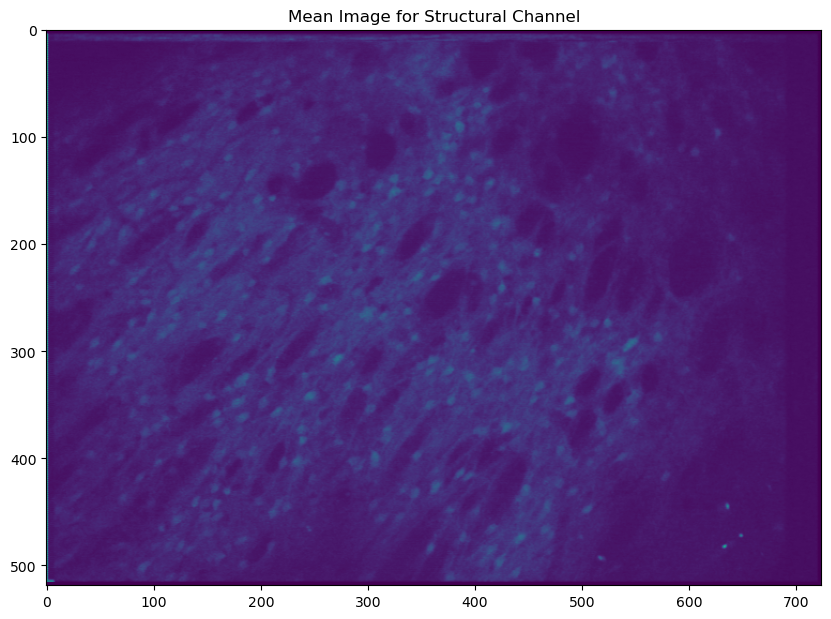

In [37]:
plt.figure(figsize=(10,10))
plt.imshow(im)
plt.title('Mean Image for Structural Channel')
print(np.shape(im))

In [ ]:
# dataset dependent parameters

rf = None                   # half-size of the patches in pixels. Should be `None` when seeded CNMF is used.
only_init = False           # has to be `False` when seeded CNMF is used
gSig = (4, 4)               # expected half size of neurons in pixels, very important for proper component detection

# params object
opts_dict = {'fnames': regVideoPath,
            'decay_time': 0.4,
            'p': 0,
            'nb': 2,
            'rf': rf,
            'only_init': only_init,
            'gSig': gSig,
            'ssub': 1,
            'tsub': 1,
            'merge_thr': 0.60}

opts = params.CNMFParams(params_dict=opts_dict)



c, dview, n_processes = cm.cluster.setup_cluster(
       backend='local', n_processes=None, single_thread=False)

## restart cluster to clean up memory
cm.stop_server(dview=dview)
c, dview, n_processes = cm.cluster.setup_cluster(
    backend='local', n_processes=None, single_thread=False)


In [17]:
regVidMap = '/mnt/Brenna_Feb2023/TdTG7_18/TdTG7_18_018/field1_gui/testingmmapFile_d1_519_d2_724_d3_1_order_C_frames_12961.mmap'
Yr, dims, T = cm.load_memmap(regVidMap)
images = np.reshape(Yr.T, [T] + list(dims), order='F') 

In [39]:
dimsList = [dims, np.shape(im)]
print(dims)
print(np.shape(meanRedImage)[0:2])
dims_comb = tuple(np.array(dimsList).max(axis=0))
print(dims_comb)



(519, 724)
(519, 724)
(519, 724)


In [42]:
avgPadded = np.pad(im, np.array(dims_comb) - meanRedImage.shape[0:1],
                'constant', constant_values=0)

newAvg = avgPadded[0:dims[0], 0:dims[1]]

(519, 724)


Text(0.5, 1.0, 'Mean Image for Structural Channel')

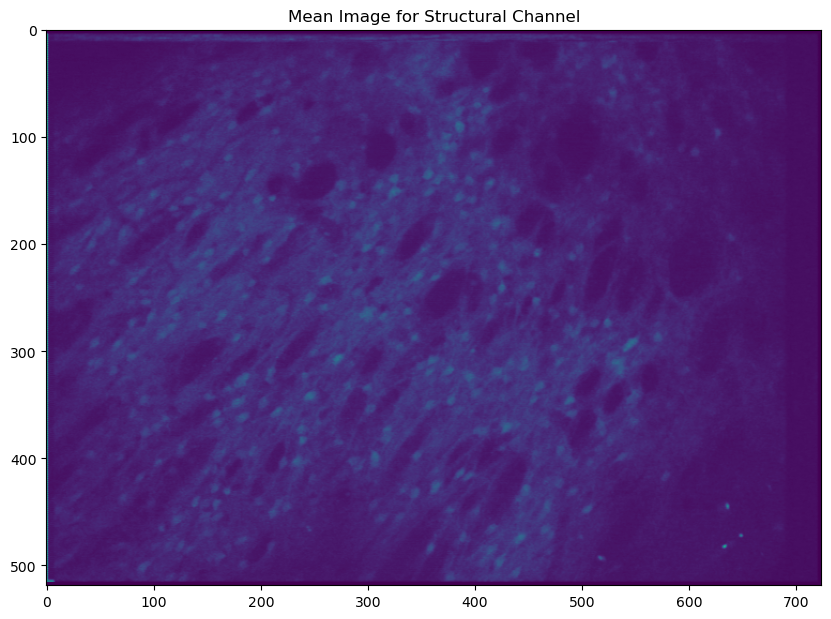

In [43]:
plt.figure(figsize=(10,10))
plt.imshow(newAvg)
plt.title('Mean Image for Structural Channel')

In [44]:
Ain = cm.base.rois.extract_binary_masks_from_structural_channel(newAvg, gSig=5, expand_method='dilation')[0]
# crd = nb_plot_contour(mR, Ain.astype('float32'), mR.shape[0], mR.shape[1], thr=0.99)
cnm_seeded = cnmf.CNMF(n_processes, params=opts, dview=dview, Ain=Ain)
cnm_seeded.fit(images)

/home/howelab/CaImAn/caiman/base/rois.py:141: FutureWarning: `selem` is a deprecated argument name for `dilation`. It will be removed in version 1.0. Please use `footprint` instead.
  temp = dilation(temp, selem=selem)


spatial support for each components given by the user


In [45]:
Cn = cm.local_correlations(images.transpose(1,2,0))
Cn[np.isnan(Cn)] = 0

In [46]:
cnm_seeded.estimates.plot_contours_nb(img=Cn)

In [47]:
# parameters for component evaluation
min_SNR = 2               # signal to noise ratio for accepting a component
rval_thr = 0.8              # space correlation threshold for accepting a component
min_cnn_thr = 0.90          # threshold for CNN based classifier
cnn_lowest = 0.30          # neurons with cnn probability lower than this value are rejected
#cnm_seeded.estimates.restore_discarded_components()
cnm_seeded.params.set('quality', {'min_SNR': min_SNR,
                           'rval_thr': rval_thr,
                           'use_cnn': True,
                           'min_cnn_thr': min_cnn_thr,
                           'cnn_lowest': cnn_lowest})

#%% COMPONENT EVALUATION
# the components are evaluated in three ways:
#   a) the shape of each component must be correlated with the data
#   b) a minimum peak SNR is required over the length of a transient
#   c) each shape passes a CNN based classifier

cnm_seeded.estimates.evaluate_components(images, cnm_seeded.params, dview=dview)


USING MODEL (keras API): /home/howelab/caiman_data/model/cnn_model.json


2023-04-18 15:22:51.809843: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


23/23 [==============================] - 0s 5ms/step


In [48]:
cnm_seeded.estimates.plot_contours_nb(img=Cn, idx=cnm_seeded.estimates.idx_components)

## accepted components
cnm_seeded.estimates.hv_view_components(img=Cn, idx=cnm_seeded.estimates.idx_components)

## rejected components
cnm_seeded.estimates.hv_view_components(img=Cn, idx=cnm_seeded.estimates.idx_components_bad)



:DynamicMap   [unit_id,scale]

In [49]:
cnm_seeded.estimates.detrend_df_f(quantileMin=8, frames_window=500)


In [52]:
cnm_seeded.estimates.select_components(use_object=True)

In [53]:
print(np.shape(cnm_seeded.estimates.A))

(375756, 570)


In [51]:
matFile = saveCaimain2Mat(cnm_seeded.estimates, '/mnt/Brenna_Feb2023/TdTG7_18/TdTG7_18_018/field1_gui', 'caimanOutputStructural', dims, 12, 0, 0)